In [1]:
#set adequate environment
import os
import sys
import theano
theano.config.gcc.cxxflags = '-march=corei7'

In [2]:
#load needed things
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.layers import Input, Activation, Dense
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pyp
import itertools
import math
import ROOT
import cPickle as pickle
from UserFunctions import *

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using Theano backend.


In [3]:
#load events
comparison = '>='
njets = 2
min4lmass = 118
max4lmass = 130

filein = open('hzz4l_2jets_m4l118-130GeV_qqZZenriched.pkl','r')
events = pickle.load( filein )
filein.close()

In [4]:
#shows events and statistics
for ik in events:
    nevents = len(events[ik])
    sumw = 0
    for i in range(nevents):
        sumw += events[ik][i][2]
    print '%s events: %i, normalized: %.4f' % (ik,nevents,sumw)
    
#only MC
summ = 0
for ik in events:
    if(ik != 'Data'):
        summ += len(events[ik])
print 'MC total events: %i' % summ    

TTZ events: 183, normalized: 0.2655
myqqZZ events: 9183, normalized: 163.4517
ZH events: 10135, normalized: 0.4547
VBF events: 38623, normalized: 3.1096
qqZZ events: 214, normalized: 1.5321
WH events: 21967, normalized: 0.6385
ttH events: 17486, normalized: 0.4770
ggZZ events: 865, normalized: 0.1468
Data events: 16, normalized: 16.0000
HJJ events: 7459, normalized: 6.8132
MC total events: 106115


In [5]:
#creates a copy from orig events
#orig_events = events
#events = {}
#events['VBF'] = orig_events['VBF']
#events['HJJ'] = orig_events['HJJ']
#events['ZH'] = orig_events['ZH']
#events['WH'] = orig_events['WH']
#events['ttH'] = orig_events['ttH']
#events['qqZZ'] = orig_events['qqZZ']
#events['ggZZ'] = orig_events['ggZZ']
#events['TTZ'] = orig_events['TTZ']
del events['myqqZZ']

In [6]:
#organize events and splits mc; data it's kept full
full_event_train, full_event_test, full_event_data = splitInputs(events, 0.6)

#just to organize index of important quantities
djet_index   = 0
mela_index   = 1
weight_index = 2

Train set size: 8
Test set size: 8


In [7]:
#to select how many jets to use;  eg. 7 = 4leptons + 3jets
nparticles = 7
features = {
    'pt' : None,
    'eta': None,
    'phi': None
    #'e'  : None
}
nfeatures = len(features)

In [8]:
#prepare train set
X = {}
Y = {}
X['train'], Y['train'], weights_train_set, scales_train_set = prepareSet(full_event_train, nparticles, nfeatures, weight_index)

siev: 23173
biev: 18659


In [9]:
#prepare test set
X['test'], Y['test'], weights_test_set, scales_test_set = prepareSet(full_event_test, nparticles, nfeatures, weight_index)

siev: 15450
biev: 23326


In [10]:
# Run classifier with cross-validation and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp


# DNN Model for VBF vs HJJ
opt = Adam()
dnn_model1 = Sequential()
dnn_model1.add(Dense(21, input_shape=(nparticles*nfeatures,), activation='relu'))
dnn_model1.add(Dense(13, activation='relu'))
dnn_model1.add(Dense(5, activation='relu'))
dnn_model1.add(Dense(1, activation='sigmoid'))
   
# load best weights
dnn_model1.load_weights("weights_best_vbf_hjj.hdf5")
# Compile model (required to make predictions)
dnn_model1.compile(loss='binary_crossentropy', optimizer=opt)

In [11]:
# DNN Model for VBF vs BKGs without HJJ
opt = Adam()
dnn_model2 = Sequential()
dnn_model2.add(Dense(21, input_shape=(nparticles*nfeatures,), activation='relu'))
dnn_model2.add(Dense(13, activation='relu'))
dnn_model2.add(Dense(5, activation='relu'))
dnn_model2.add(Dense(1, activation='sigmoid'))
   
# load best weights
dnn_model2.load_weights("weights_best_vbf_ttHWHqqZZggZZttZ.hdf5")
# Compile model (required to make predictions)
dnn_model2.compile(loss='binary_crossentropy', optimizer=opt)

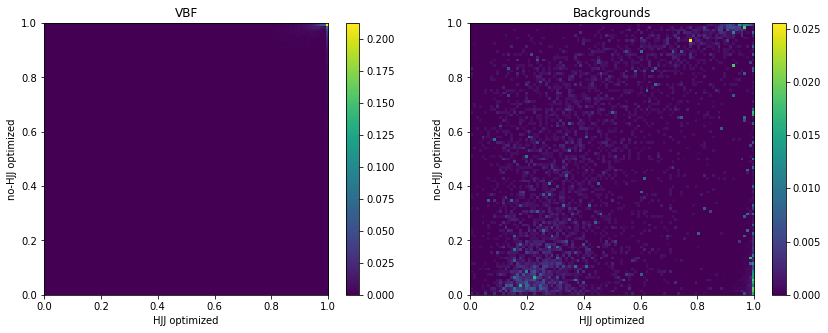

In [12]:
x = dnn_model1.predict(X['train'])
y = dnn_model2.predict(X['train'])

xs = []
ys = []
ws = []
xb = []
yb = []
wb = []
for i in range(len(x)):
    if(Y['train'][i] == 1):
        xs.append(x[i][0])
        ys.append(y[i][0])
        ws.append(weights_train_set[i])
    else:
        xb.append(x[i][0])
        yb.append(y[i][0])
        wb.append(weights_train_set[i])

from matplotlib.colors import LogNorm
fig = pyp.figure()
fig.set_figheight(5)
fig.set_figwidth(14)

fig1 = fig.add_subplot(121)
bins = np.linspace(0, 1, 100)
pyp.hist2d(xs, ys, bins=bins, weights=ws)#, norm=LogNorm())#, vmin=1.e-7, vmax=1.)
pyp.colorbar()
pyp.title('VBF')
pyp.xlabel('HJJ optimized')
pyp.ylabel('no-HJJ optimized')

fig2 = fig.add_subplot(122)
pyp.hist2d(xb, yb, bins=bins, weights=wb)#, norm=LogNorm())#, vmin=1.e-7, vmax=1.)
pyp.colorbar()
pyp.title('Backgrounds')
pyp.xlabel('HJJ optimized')
pyp.ylabel('no-HJJ optimized')

pyp.show()

In [13]:
#train the network
inputs_train = []
for i in range(len(Y['train'])):
    inputs_train.append([x[i][0],y[i][0]])

xt = dnn_model1.predict(X['test'])
yt = dnn_model2.predict(X['test'])
inputs_test = []
for i in range(len(Y['test'])):
    inputs_test.append([xt[i][0],yt[i][0]])
    
    
opt = Adam()
dnn_modelf = Sequential()
dnn_modelf.add(Dense(8, input_shape=(2,), activation='relu'))
dnn_model2.add(Dense(4, activation='relu'))
dnn_modelf.add(Dense(1, activation='sigmoid'))
dnn_modelf.compile(loss='binary_crossentropy', optimizer=opt)

early_stopping = EarlyStopping(monitor='val_loss', patience=30)
filepath="weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

history = dnn_modelf.fit(inputs_train, Y['train'],
                         validation_data=(inputs_test, Y['test']),
                         epochs=400, batch_size=64, 
                         verbose=2, callbacks=[early_stopping, checkpoint])

Train on 41832 samples, validate on 38776 samples
Epoch 1/400
0s - loss: 0.6390 - val_loss: 0.5280
Epoch 2/400
0s - loss: 0.4539 - val_loss: 0.3771
Epoch 3/400
0s - loss: 0.3763 - val_loss: 0.3459
Epoch 4/400
0s - loss: 0.3634 - val_loss: 0.3356
Epoch 5/400
0s - loss: 0.3582 - val_loss: 0.3396
Epoch 6/400
0s - loss: 0.3554 - val_loss: 0.3307
Epoch 7/400
0s - loss: 0.3535 - val_loss: 0.3343
Epoch 8/400
0s - loss: 0.3521 - val_loss: 0.3320
Epoch 9/400
0s - loss: 0.3510 - val_loss: 0.3308
Epoch 10/400
0s - loss: 0.3500 - val_loss: 0.3309
Epoch 11/400
0s - loss: 0.3493 - val_loss: 0.3313
Epoch 12/400
0s - loss: 0.3487 - val_loss: 0.3273
Epoch 13/400
0s - loss: 0.3482 - val_loss: 0.3281
Epoch 14/400
0s - loss: 0.3479 - val_loss: 0.3340
Epoch 15/400
0s - loss: 0.3477 - val_loss: 0.3267
Epoch 16/400
0s - loss: 0.3475 - val_loss: 0.3280
Epoch 17/400
0s - loss: 0.3473 - val_loss: 0.3303
Epoch 18/400
0s - loss: 0.3472 - val_loss: 0.3253
Epoch 19/400
0s - loss: 0.3471 - val_loss: 0.3288
Epoch 20/

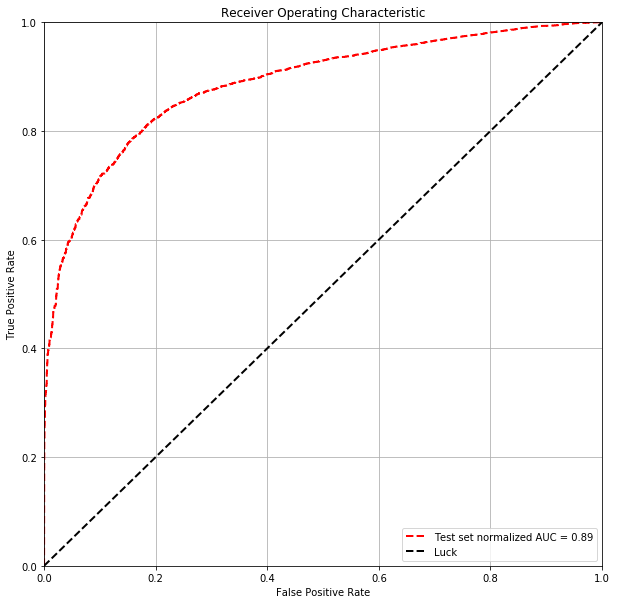

In [14]:
fig = pyp.figure(figsize=(10,10))

#test set normalized roc
Y_score = dnn_modelf.predict(inputs_test)
fpr, tpr, thresholds = roc_curve(Y['test'], Y_score, sample_weight=weights_test_set)
roc_auc = auc(fpr, tpr)
pyp.plot(fpr, tpr, linestyle='--', lw=2, color='red', label='Test set normalized AUC = %0.2f' % roc_auc)

#random
pyp.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Luck')

pyp.xlim([0, 1.0])
pyp.ylim([0, 1.0])
pyp.xlabel('False Positive Rate')
pyp.ylabel('True Positive Rate')
pyp.title('Receiver Operating Characteristic')
pyp.legend(loc="lower right")
pyp.grid(True)
pyp.show()

In [15]:
#prepare Djet & MELA for test (only MC - beacuse needs to be 50%)
Ydjet = {}
Ydjet['signal'] = []
Ydjet['background'] = []

Ymela = {}
Ymela['signal'] = []
Ymela['background'] = []

for ik in full_event_test:
    if(ik == 'Data'):
        continue
    if(ik == 'VBF'):
        for i in range(len(full_event_test[ik])):
            Ydjet['signal'].append( full_event_test[ik][i][djet_index] )
            Ymela['signal'].append( full_event_test[ik][i][mela_index] )
    else:
        for i in range(len(full_event_test[ik])):
            Ydjet['background'].append( full_event_test[ik][i][djet_index] )
            Ymela['background'].append( full_event_test[ik][i][mela_index] )
            
Ydjet_test_set = np.concatenate([Ydjet['signal'],Ydjet['background']])
Ymela_test_set = np.concatenate([Ymela['signal'],Ymela['background']])

In [16]:
#plot S/B ratio vs S eff (only test set)
signal_sumw = 0
for i in range(len(full_event_test['VBF'])):
    signal_sumw += full_event_test['VBF'][i][weight_index]

djet_sb = []
djet_seff = []
mela_sb = []
mela_seff = []
dnn_sb = []
dnn_seff = []
djet_cuts = []
mela_cuts = []
dnn_cuts = []

full_sdjet = []
full_bdjet = []
full_smela = []
full_bmela = []
full_sdnn = []
full_bdnn = []
sweights = []
bweights = []

for cut in range(200):
    icut = cut/100.
    if(cut % 2 != 0):
        continue
    
    s_djet = 0
    s_mela = 0
    s_dnn = 0
    b_djet = 0
    b_mela = 0
    b_dnn = 0
    for i in range(len(Y['test'])):
        djet = Ydjet_test_set[i]
        mela = Ymela_test_set[i]
        dnn = Y_score[i][0]
        weight = weights_test_set[i]
        
        if(Y['test'][i] == 1):
            if(cut == 0):
                full_sdjet.append( djet )
                full_smela.append( mela )
                full_sdnn.append( dnn )
                sweights.append( weight )
            
            if(djet > icut):
                s_djet += weight
            if(mela > icut):
                s_mela += weight
            if(dnn > icut):
                s_dnn += weight
        else:
            if(cut == 0):
                full_bdjet.append( djet )
                full_bmela.append( mela )
                full_bdnn.append( dnn )
                bweights.append( weight )
            
            if(djet > icut):
                b_djet += weight
            if(mela > icut):
                b_mela += weight
            if(dnn > icut):
                b_dnn += weight
    
    if(b_djet > 0):
        djet_sb.append(s_djet/b_djet)
        djet_seff.append(s_djet/signal_sumw)
        djet_cuts.append(icut)
    
    if(b_mela > 0):
        mela_sb.append(s_mela/b_mela)
        mela_seff.append(s_mela/signal_sumw)
        mela_cuts.append(icut)
    
    if(b_dnn > 0):
        #print 'cut: %.3f, s_lstm: %.3f, b_lstm: %.3f, sb: %.3f' % (icut, s_lstm,b_lstm,s_lstm/b_lstm)
        dnn_sb.append(s_dnn/b_dnn)
        dnn_seff.append(s_dnn/signal_sumw)
        dnn_cuts.append(icut)

In [17]:
fig = pyp.figure()
fig.set_figheight(5)
fig.set_figwidth(14)

fig1 = fig.add_subplot(131)
bins = np.linspace(0, 3, 100)
pyp.hist(full_sdjet, bins, weights=sweights, alpha=0.5, color='red', label='s_Djet')
pyp.hist(full_bdjet, bins, weights=bweights, alpha=0.5, color='blue',label='b_Djet')
pyp.xlabel('Djet')
pyp.ylabel('Normalized')
pyp.ylim([0.001,10])
pyp.legend(loc='upper right')
pyp.gca().set_yscale("log")

fig2 = fig.add_subplot(132)
bins = np.linspace(-0.05, 1.05, 100)
pyp.hist(full_smela, bins, weights=sweights, alpha=0.5, color='red', label='s_MELA')
pyp.hist(full_bmela, bins, weights=bweights, alpha=0.5, color='blue',label='b_MELA')
pyp.xlabel('MELA')
pyp.ylim([0.001,10])
pyp.legend(loc='upper right')
pyp.gca().set_yscale("log")

fig3 = fig.add_subplot(133)
bins = np.linspace(-0.05, 1.05, 100)
pyp.hist(full_sdnn, bins, weights=sweights, alpha=0.5, color='red', label='s_DNN')
pyp.hist(full_bdnn, bins, weights=bweights, alpha=0.5, color='blue',label='b_DNN')
pyp.xlabel('DNN')
pyp.ylim([0.001,10])
pyp.legend(loc='upper right')
pyp.gca().set_yscale("log")

pyp.tight_layout()
fig = pyp.show()

AttributeError: 'DejaVuSansFonts' object has no attribute 'render_glyph'

AttributeError: 'DejaVuSansFonts' object has no attribute 'render_glyph'

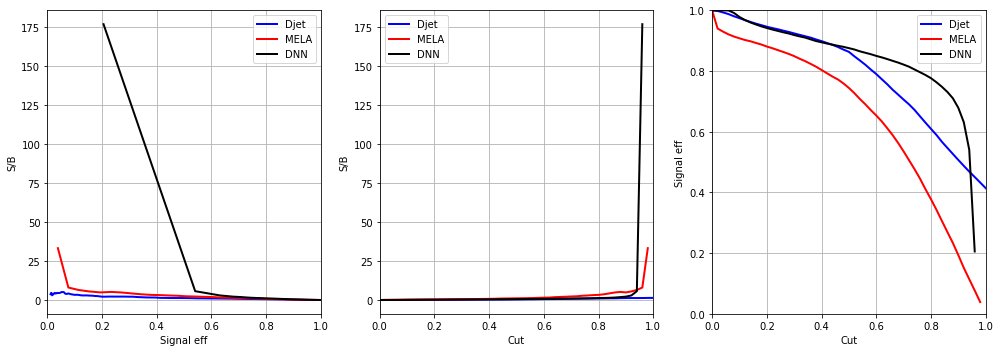

In [18]:
fig = pyp.figure()
fig.set_figheight(5)
fig.set_figwidth(14)

fig1 = fig.add_subplot(131)
pyp.plot(djet_seff, djet_sb, lw=2, color='blue', label='Djet')
pyp.plot(mela_seff, mela_sb, lw=2, color='red', label='MELA')
pyp.plot(dnn_seff, dnn_sb, lw=2, color='black', label='DNN')
pyp.xlim([0, 1])
pyp.xlabel('Signal eff')
#pyp.ylim([0, 10])
pyp.ylabel('S/B')
pyp.legend(loc="upper right")
pyp.grid(True)

fig1 = fig.add_subplot(132)
pyp.plot(djet_cuts, djet_sb, lw=2, color='blue', label='Djet')
pyp.plot(mela_cuts, mela_sb, lw=2, color='red', label='MELA')
pyp.plot(dnn_cuts, dnn_sb, lw=2, color='black', label='DNN')
pyp.xlim([0, 1])
#pyp.ylim([0, 10])
pyp.xlabel('Cut')
pyp.ylabel('S/B')
pyp.legend(loc="upper left")
pyp.grid(True)

fig1 = fig.add_subplot(133)
pyp.plot(djet_cuts, djet_seff, lw=2, color='blue', label='Djet')
pyp.plot(mela_cuts, mela_seff, lw=2, color='red', label='MELA')
pyp.plot(dnn_cuts, dnn_seff, lw=2, color='black', label='DNN')
pyp.xlim([0, 1])
pyp.ylim([0, 1])
pyp.xlabel('Cut')
pyp.ylabel('Signal eff')
pyp.legend(loc="upper right")
pyp.grid(True)

pyp.tight_layout()
fig = pyp.show()

******** ROCs from DNN *********
VBF vs  TTZ  -- ROC AUC: 0.32
VBF vs  ZH  -- ROC AUC: 0.41
VBF vs  qqZZ  -- ROC AUC: 0.41
VBF vs  WH  -- ROC AUC: 0.41
VBF vs  ttH  -- ROC AUC: 0.44
VBF vs  ggZZ  -- ROC AUC: 0.45
VBF vs  HJJ  -- ROC AUC: 0.12


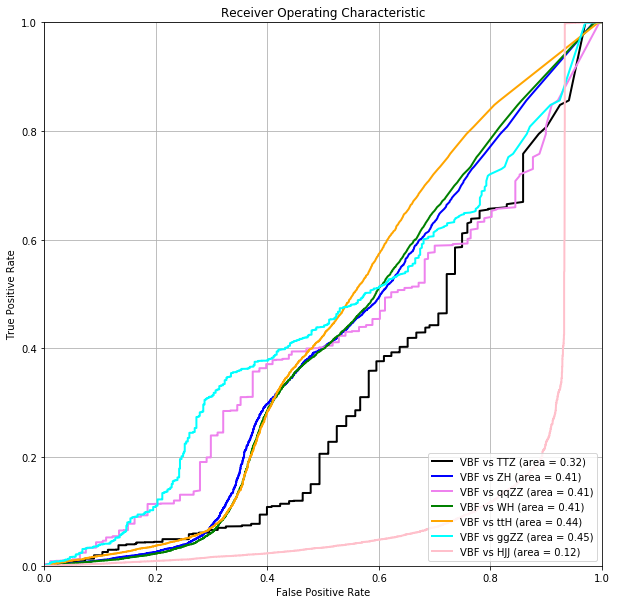

In [19]:
#normalized ROCs
print '******** ROCs from DNN *********'
fig = pyp.figure(figsize=(10,10))
colors = ['black','blue','violet','green','orange','cyan','pink','yellow','red','gray','brown']

ic = 0
for ik in full_event_test:
    if(ik == 'VBF' or ik == 'Data'):
        continue
        
    Y_truth = []
    X = []
    Weights = []
    #for VBF
    for i in range(len(full_event_test['VBF'])):
        Y_truth.append(1)
        x = []
        Weights.append(full_event_test['VBF'][i][weight_index])
        for ip in range(nparticles):
            for j in range(nfeatures):
                prop = full_event_test['VBF'][i][ip+6][j]
                if(prop != -999):
                    x.append(prop)
                else:
                    x.append(0)
        X.append(x)

    #for the BKGs
    for i in range(len(full_event_test[ik])):
        Y_truth.append(0)
        x = []
        Weights.append(full_event_test[ik][i][weight_index])
        for ip in range(nparticles):
            for j in range(nfeatures):
                prop = full_event_test[ik][i][ip+6][j]
                if(prop != -999):
                    x.append(prop)
                else:
                    x.append(0)
        X.append(x)        
                
    Y_score1 = dnn_model1.predict(X)
    Y_score2 = dnn_model2.predict(X)
    xc = []
    for i in range(len(Y_score1)):
        xc.append([Y_score1[i][0],Y_score2[i][0]])
    Y_score = dnn_modelf.predict(xc)
    fpr, tpr, thresholds = roc_curve(Y_truth, Y_score, sample_weight=Weights)
    roc_auc = auc(fpr, tpr)
    print 'VBF vs ',ik,' -- ROC AUC: %.2f' % roc_auc
    pyp.plot(fpr, tpr, lw=2, color=colors[ic], label=('VBF vs %s (area = %0.2f)' % (ik,roc_auc)))
    ic += 1
    
pyp.xlim([0, 1.0])
pyp.ylim([0, 1.0])
pyp.xlabel('False Positive Rate')
pyp.ylabel('True Positive Rate')
pyp.title('Receiver Operating Characteristic')
pyp.legend(loc="lower right")
pyp.grid(True)
pyp.show()